In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Link up Chicago crime events with chicago address locations

Simple as it says, really.

- Load the database of address locations
- Load the original crime data
- For each crime location, find the closest building point
- Then find all building points within 100m of that point, and choose one at random.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import os, lzma
import numpy as np
import tilemapbase
import open_cp.geometry
open_cp.geometry.configure_gdal()
import open_cp.logger
open_cp.logger.log_to_true_stdout("opencrimedate")

import opencrimedata.address
import opencrimedata.chicago
import opencrimedata.replace

proj = opencrimedata.chicago.projector()

### Load crime data

In [4]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
filename = os.path.join(datadir, "openaddr-collected-us_midwest.zip")

def gen():
    filename = os.path.join(datadir, "chicago_all.csv.xz")
    with lzma.open(filename, "rt") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

### Load address database

In [3]:
address_matcher = opencrimedata.address.AddressMatch.from_zip(filename, "il", "cook", proj)

In [4]:
row = next(gen())
row, address_matcher.closest(proj(*row.point))

(Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427)),
 (array(['10824', 'SOUTH AVENUE G'], 
        dtype='<U40'), array([ 366709.26919737,  558910.25552585])))

## Do the redistribution

In [6]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        address, pt = address_matcher.closest(proj(*row.point))
        _, points = address_matcher.all_in_disc(pt, 100)
        i = np.random.choice(len(points))
        pt = points[i]
        return opencrimedata.chicago.row_with_new_position(row, *proj(*pt, inverse=True))
    
assign = AssignNew(gen(), seed=1234)
with lzma.open(os.path.join(datadir, "chicago_redist_to_buildings.csv.xz"), "wt", newline="") as f:
    opencrimedata.chicago.write(f, assign)

# Plots

In [5]:
def gen_new():
    filename = os.path.join(datadir, "chicago_redist_to_buildings.csv.xz")
    with lzma.open(filename, "rt") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

In [6]:
points, points_new = [], []
for row, row_new in zip(gen(), gen_new()):
    assert row.id == row_new.id
    points.append(tilemapbase.project(*row.point))
    points_new.append(tilemapbase.project(*row_new.point))

points = np.asarray(points)
points_new = np.asarray(points_new)

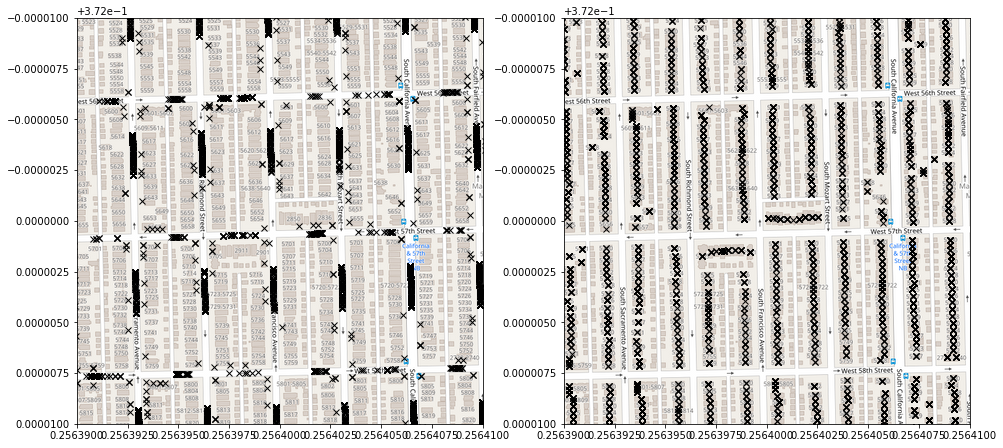

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

for ax in axes:
    ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00002)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
    plotter.plot(ax)
axes[0].scatter(*points.T, marker="x", linewidth=1, color="black")
axes[1].scatter(*points_new.T, marker="x", linewidth=1, color="black")

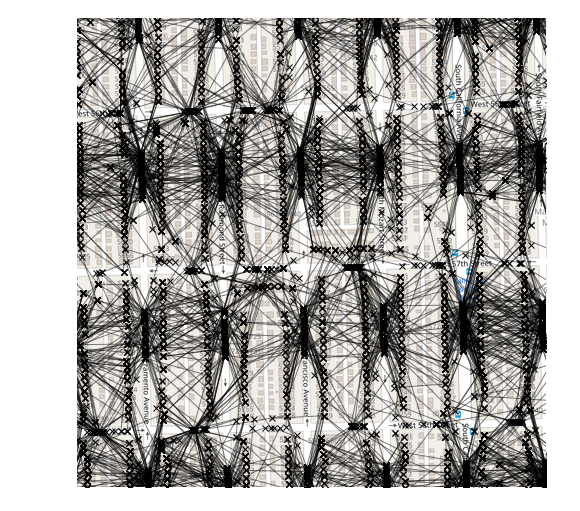

In [7]:
fig, ax = plt.subplots(figsize=(8,8))

ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

lines = list(zip(points, points_new))
lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black", alpha=0.5)
ax.add_collection(lines)
ax.scatter(*points.T, marker="x", linewidth=1, color="black")
ax.scatter(*points_new.T, marker="x", linewidth=1, color="black")
ax.set_axis_off()
fig.tight_layout()

In [8]:
fig.savefig("chicago_buildings_1", dpi=150)